In [ ]:
def load_file(filepath):

    with open(filepath, 'r', encoding='utf-8') as file:
        sentences = file.readlines()
    return [sentence.strip() for sentence in sentences]

# Load all files
eng_dev = load_file('/content/eng_Latn.dev')
eng_devtest = load_file('/content/eng_Latn.devtest')
urdu_dev = load_file('/content/urd_Arab.dev')
urdu_devtest = load_file('/content/urd_Arab.devtest')

# Data Preprocessing and Tensor Creation:
Following steps were followed:
- Concatenation of .dev and .devtest files for both urdu and english.
- Preprocessing: preserve abbreviations, remove extra spaces, and add spaces around punctuation marks.
- Tokenization
- Vocabulary creation
- Converting sentences (tokenized) to tensors
- Shuffling and splitting into validation, test, and training sets.

In [ ]:
# Combine sentences from dev and devtest for English and Urdu
english_sentences = eng_dev + eng_devtest
urdu_sentences = urdu_dev + urdu_devtest

assert len(english_sentences) == len(urdu_sentences), "Mismatch in sentence alignment!"

print(f"Total aligned sentences: {len(english_sentences)}")


Total aligned sentences: 2009


In [ ]:
import re
def preprocess_text(sentence, lang="urdu"):
    if lang == "english":
        # Preserve abbreviations like U.S., U.K., etc.
        abbreviation_pattern = r'\b([A-Za-z])\.([A-Za-z])\.'
        sentence = re.sub(abbreviation_pattern, r'\1.\2.', sentence)

        # Add space around other punctuation
        sentence = re.sub(r"([!?])", r" \1 ", sentence)  # Exclude periods in abbreviations
        sentence = re.sub(r"(?<!\w)\.(?!\w)", r" . ", sentence)
        # convert to lowercase
        sentence = sentence.lower()

    elif lang == "urdu":
        # Add space around Urdu full stop
        sentence = re.sub(r"۔", " ۔ ", sentence)

    # Remove extra spaces
    sentence = re.sub(r"\s+", " ", sentence).strip()
    return sentence

english_sentences = [preprocess_text(sentence, lang="english") for sentence in english_sentences]
urdu_sentences = [preprocess_text(sentence, lang="urdu") for sentence in urdu_sentences]

In [ ]:
#tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

english_tokenized = [nltk.word_tokenize(sentence) for sentence in english_sentences]
urdu_tokenized = [nltk.word_tokenize(sentence) for sentence in urdu_sentences]

print(f"Tokenized English sentences: {english_tokenized[:5]}")
print(f"Tokenized Urdu sentences: {urdu_tokenized[:5]}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokenized English sentences: [['on', 'monday', ',', 'scientists', 'from', 'the', 'stanford', 'university', 'school', 'of', 'medicine', 'announced', 'the', 'invention', 'of', 'a', 'new', 'diagnostic', 'tool', 'that', 'can', 'sort', 'cells', 'by', 'type', ':', 'a', 'tiny', 'printable', 'chip', 'that', 'can', 'be', 'manufactured', 'using', 'standard', 'inkjet', 'printers', 'for', 'possibly', 'about', 'one', 'u.s.', 'cent', 'each', '.'], ['lead', 'researchers', 'say', 'this', 'may', 'bring', 'early', 'detection', 'of', 'cancer', ',', 'tuberculosis', ',', 'hiv', 'and', 'malaria', 'to', 'patients', 'in', 'low-income', 'countries', ',', 'where', 'the', 'survival', 'rates', 'for', 'illnesses', 'such', 'as', 'breast', 'cancer', 'can', 'be', 'half', 'those', 'of', 'richer', 'countries', '.'], ['the', 'jas', '39c', 'gripen', 'crashed', 'onto', 'a', 'runway', 'at', 'around', '9:30', 'am', 'local', 'time', '(', '0230', 'utc', ')', 'and', 'exploded', ',', 'closing', 'the', 'airport', 'to', 'commerci

# Word2Vec

In [ ]:
from gensim.models import Word2Vec

# Word2Vec for English
english_w2v_model = Word2Vec(sentences=english_tokenized, vector_size=300, window=5, min_count=1, workers=4)

# Word2Vec for Urdu
urdu_w2v_model = Word2Vec(sentences=urdu_tokenized, vector_size=300, window=5, min_count=1, workers=4)

english_w2v_model.save("english_word2vec.model")
urdu_w2v_model.save("urdu_word2vec.model")

In [ ]:
import numpy as np
def build_vocab_with_embeddings(tokenized_sentences, w2v_model, embedding_dim):
    vocab = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
    index = len(vocab)
    embeddings = [np.zeros(embedding_dim),  # For <PAD>
                  np.random.uniform(-0.1, 0.1, embedding_dim),  # For <SOS>
                  np.random.uniform(-0.1, 0.1, embedding_dim),  # For <EOS>
                  np.random.uniform(-0.1, 0.1, embedding_dim)]  # For <UNK>

    for sentence in tokenized_sentences:
        for word in sentence:
            if word not in vocab:
                vocab[word] = index
                if word in w2v_model.wv:
                    embeddings.append(w2v_model.wv[word])
                else:
                    embeddings.append(np.random.uniform(-0.1, 0.1, embedding_dim))  # For OOV words
                index += 1

    return vocab, np.array(embeddings)

english_vocab, english_embeddings = build_vocab_with_embeddings(english_tokenized, english_w2v_model, 300)
urdu_vocab, urdu_embeddings = build_vocab_with_embeddings(urdu_tokenized, urdu_w2v_model, 300)

In [ ]:
print(f"English vocab size: {len(english_vocab)}")
print(f"Urdu vocab size: {len(urdu_vocab)}")

English vocab size: 8651
Urdu vocab size: 9555


In [ ]:
# def build_vocab(tokenized_sentences):
#     vocab = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
#     index = 4
#     for sentence in tokenized_sentences:
#         for word in sentence:
#             if word not in vocab:
#                 vocab[word] = index
#                 index += 1
#     return vocab

# english_vocab = build_vocab(english_tokenized)
# urdu_vocab = build_vocab(urdu_tokenized)

# print("English vocab size:", len(english_vocab))
# print("Urdu vocab size:", len(urdu_vocab))

English vocab size: 8651
Urdu vocab size: 9555


In [ ]:
assert '<PAD>' in english_vocab and '<PAD>' in urdu_vocab, "Missing <PAD> in vocab!"
assert '<SOS>' in english_vocab and '<SOS>' in urdu_vocab, "Missing <SOS> in vocab!"
assert '<EOS>' in english_vocab and '<EOS>' in urdu_vocab, "Missing <EOS> in vocab!"
assert '<UNK>' in english_vocab and '<UNK>' in urdu_vocab, "Missing <UNK> in vocab!"

print("English and Urdu vocabularies contain required tokens.")

English and Urdu vocabularies contain required tokens.


In [ ]:
import torch
#convert sentences to tensors

def sentences_to_tensor(tokenized_sentences, vocab, max_length=50):
    tensors = []
    for sentence in tokenized_sentences:
        tokens = [vocab.get(word, vocab['<UNK>']) for word in sentence]
        # Add <SOS> and <EOS>
        tokens = [vocab['<SOS>']] + tokens[:max_length-2] + [vocab['<EOS>']]
        # Pad to max_length
        tokens += [vocab['<PAD>']] * (max_length - len(tokens))
        tensors.append(tokens)
    return torch.tensor(tensors, dtype=torch.long)

max_length = 50
english_tensors = sentences_to_tensor(english_tokenized, english_vocab, max_length)
urdu_tensors = sentences_to_tensor(urdu_tokenized, urdu_vocab, max_length)

print("English tensor shape:", english_tensors.shape)
print("Urdu tensor shape:", urdu_tensors.shape)

English tensor shape: torch.Size([2009, 50])
Urdu tensor shape: torch.Size([2009, 50])


In [ ]:
assert torch.max(english_tensors) < len(english_vocab), "English tensors contain out-of-range indices!"
assert torch.max(urdu_tensors) < len(urdu_vocab), "Urdu tensors contain out-of-range indices!"
assert torch.min(english_tensors) >= 0, "English tensors contain negative indices!"
assert torch.min(urdu_tensors) >= 0, "Urdu tensors contain negative indices!"

print("English and Urdu tensors contain valid indices.")

English and Urdu tensors contain valid indices.


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
train_eng, test_eng, train_urdu, test_urdu = train_test_split(
    english_tensors, urdu_tensors, test_size=0.3, random_state=42
)
val_eng, test_eng, val_urdu, test_urdu = train_test_split(
    test_eng, test_urdu, test_size=0.5, random_state=42
)

print(f"Training set: {len(train_eng)} samples")
print(f"Validation set: {len(val_eng)} samples")
print(f"Test set: {len(test_eng)} samples")

Training set: 1406 samples
Validation set: 301 samples
Test set: 302 samples


In [ ]:
print(f"Training set english first 5 samples: {train_eng[:5]}")
print(f"Training set urdu first 5 samples: {train_urdu[:5]}")

Training set english first 5 samples: tensor([[   1,   43,   13,  310, 3859, 3865,  348, 3866, 3867,   37, 1601, 2050,
         1302,   44,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   1,  432,   17, 1613, 2908, 3230,  853, 3786,    6,  701,   58,   17,
         3787, 3788, 3789,    6,   13,   17,  627, 3790, 3791,   25, 3792,    6,
         3793, 2464,   58, 2843, 3794,    9, 2819, 2065,  612, 2172, 3795,   44,
            2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   1,  773, 1731,  505,    9, 5740, 5695,   60, 5716, 1964,   56, 5741,
           21,    9, 2209, 1327, 5742,  580, 2141,   58, 5619, 5743,   44,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0, 

In [ ]:
# Ensure split tensors are valid
for split_name, split_data in zip(
    ["train_eng", "val_eng", "test_eng", "train_urdu", "val_urdu", "test_urdu"],
    [train_eng, val_eng, test_eng, train_urdu, val_urdu, test_urdu]
):
    assert torch.max(split_data) < len(english_vocab) if "eng" in split_name else len(urdu_vocab), \
        f"{split_name} contains out-of-range indices!"
    assert torch.min(split_data) >= 0, f"{split_name} contains negative indices!"
    print(f"{split_name} indices are valid.")


train_eng indices are valid.
val_eng indices are valid.
test_eng indices are valid.
train_urdu indices are valid.
val_urdu indices are valid.
test_urdu indices are valid.


In [ ]:
print("English vocab size:", len(english_vocab))
print("Urdu vocab size:", len(urdu_vocab))
print("Max English token index:", english_tensors.max().item())
print("Max Urdu token index:", urdu_tensors.max().item())


English vocab size: 8651
Urdu vocab size: 9555
Max English token index: 8650
Max Urdu token index: 9554


In [ ]:
import torch.nn as nn
urdu_embedding_layer = nn.Embedding.from_pretrained(torch.tensor(urdu_embeddings, dtype=torch.float32), freeze=False)
assert urdu_embedding_layer.num_embeddings == len(urdu_vocab), "Mismatch in vocabulary size and embedding layer."

In [ ]:
print(f"Number of embeddings: {english_embeddings.shape[0]}")
print(f"Vocabulary size: {len(english_vocab)}")


Number of embeddings: 8651
Vocabulary size: 8651


# LSTM Cell

##Forward pass arguments:
- x (torch.Tensor): Input tensor of shape (batch_size, input_size).
- h_prev (torch.Tensor): Previous hidden state of shape (batch_size, hidden_size).
- c_prev (torch.Tensor): Previous cell state of shape (batch_size, hidden_size).

## Forward pass outputs:      
- h_t (torch.Tensor): Current hidden state.
- c_t (torch.Tensor): Current cell state.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMCell(nn.Module):
    #constructor
    def __init__(self, input_size, hidden_size):

        super(LSTMCell, self).__init__()
        print("LSTM cell with " + str(input_size) + " input size and " + str(hidden_size) + " hidden size")
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights for gates and candidate cell
        self.W_forget = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_input = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_candidate = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_output = nn.Linear(input_size + hidden_size, hidden_size)


    # Forward pass
    def forward(self, x, h_prev, c_prev):
        # Concatenate input and hidden state
        combined = torch.cat((x, h_prev), dim=1)  # Shape: (batch_size, input_size + hidden_size)

        forget_gate = torch.sigmoid(self.W_forget(combined))
        input_gate = torch.sigmoid(self.W_input(combined))
        candidate_tilde = torch.tanh(self.W_candidate(combined))
        cell_state = forget_gate * c_prev + input_gate * candidate_tilde
        output_gate = torch.sigmoid(self.W_output(combined))
        hidden_gate = output_gate * torch.tanh(cell_state)

        # All have Shape: (batch_size, hidden_size)
        return hidden_gate, cell_state

#Encoder of LSTM


In [ ]:
class Encoder(nn.Module):
    def __init__(self, embedding_layer, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding_layer
        self.lstm_cell = LSTMCell(embedding_layer.embedding_dim, hidden_size)

    def forward(self, x):
        batch_size, seq_length = x.size()
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        cell = torch.zeros(batch_size, self.hidden_size).to(x.device)

        all_hidden_states = []
        for t in range(seq_length):
            x_t = self.embedding(x[:, t]) #word2vec embedding
            hidden, cell = self.lstm_cell(x_t, hidden, cell)
            all_hidden_states.append(hidden.unsqueeze(1))

        all_hidden_states = torch.cat(all_hidden_states, dim=1)
        return all_hidden_states, hidden, cell

#Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_length, hidden_size)

        seq_length = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, seq_length, 1)
        energy = torch.tanh(self.attention(torch.cat((hidden, encoder_outputs), dim=2)))
        attention_weights = torch.softmax(self.v(energy).squeeze(2), dim=1)  # (batch_size, seq_length)

        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)  # (batch_size, 1, hidden_size)
        return context.squeeze(1), attention_weights

# Decoder for LSTM Cell


In [ ]:
class Decoder(nn.Module):
    def __init__(self, embedding_layer, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.embedding = embedding_layer
        self.attention = Attention(hidden_size)
        self.lstm_cell = LSTMCell(embedding_layer.embedding_dim + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h, c, encoder_outputs):

      x = self.embedding(x).squeeze(1)  # (batch_size, embedding_dim)
      context, attention_weights = self.attention(h, encoder_outputs)
      x_context = torch.cat((x, context), dim=1)
      h, c = self.lstm_cell(x_context, h, c)
      output = self.fc(h)  # (batch_size, output_size)
      return output, h, c, attention_weights

# Seq2Seq Model

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        encoder_outputs, hidden, cell = self.encoder(src)

        batch_size, tgt_seq_length = tgt.size()
        outputs = torch.zeros(batch_size, tgt_seq_length, self.decoder.output_size).to(src.device)

        decoder_input = tgt[:, 0].unsqueeze(1)  # Start with <SOS>
        for t in range(1, tgt_seq_length):
            output, hidden, cell, _ = self.decoder(decoder_input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output

            # Decide to use teacher forcing
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1).unsqueeze(1)  # Predicted word
            decoder_input = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#Initialize embedding layers from word2vec pretrained
english_embedding_layer = nn.Embedding.from_pretrained(torch.tensor(english_embeddings, dtype=torch.float32), freeze=False)
urdu_embedding_layer = nn.Embedding.from_pretrained(torch.tensor(urdu_embeddings, dtype=torch.float32), freeze=False)

hidden_size = 256
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create DataLoader
dataset = TensorDataset(train_urdu, train_eng)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# urdu to english nmt
encoder = Encoder(urdu_embedding_layer, hidden_size)
decoder = Decoder(english_embedding_layer, hidden_size, len(english_vocab))
model = Seq2Seq(encoder, decoder).to(device)

#Loss function
criterion = nn.CrossEntropyLoss(ignore_index=english_vocab["<PAD>"]) #ignore <PAD>
optimizer = optim.Adam(model.parameters(), lr=0.001)

#print src and target from dataloader
for src, tgt in dataloader:
  print(f"src shape: {src.shape}, max index: {torch.max(src)}, min index: {torch.min(src)}")
  print(f"tgt shape: {tgt.shape}, max index: {torch.max(tgt)}, min index: {torch.min(tgt)}")
  break

num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  total_loss = 0.0
  for src, tgt in dataloader:
    src, tgt = src.to(device), tgt.to(device)
    optimizer.zero_grad()
    outputs = model(src, tgt)
    output = outputs[:, 1:].reshape(-1, outputs.shape[2])
    tgt = tgt[:, 1:].reshape(-1)
    loss = criterion(output, tgt)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")
  # Save the model checkpoint after each epoch
  checkpoint_path = f"seq2seq_checkpoint_epoch_{epoch}.pth"
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': total_loss / len(dataloader),
      'english_vocab': english_vocab,
      'urdu_vocab': urdu_vocab,
      }, checkpoint_path)
  print(f"Checkpoint saved at {checkpoint_path}")

Using device: cpu
LSTM cell with 300 input size and 256 hidden size
LSTM cell with 556 input size and 256 hidden size
src shape: torch.Size([32, 50]), max index: 9221, min index: 0
tgt shape: torch.Size([32, 50]), max index: 8339, min index: 0
Epoch 1/10, Loss: 7.4263
Checkpoint saved at seq2seq_checkpoint_epoch_0.pth
Epoch 2/10, Loss: 6.7477
Checkpoint saved at seq2seq_checkpoint_epoch_1.pth
Epoch 3/10, Loss: 6.6428
Checkpoint saved at seq2seq_checkpoint_epoch_2.pth
Epoch 4/10, Loss: 6.5685
Checkpoint saved at seq2seq_checkpoint_epoch_3.pth
Epoch 5/10, Loss: 6.5080
Checkpoint saved at seq2seq_checkpoint_epoch_4.pth
Epoch 6/10, Loss: 6.4427
Checkpoint saved at seq2seq_checkpoint_epoch_5.pth
Epoch 7/10, Loss: 6.3678
Checkpoint saved at seq2seq_checkpoint_epoch_6.pth
Epoch 8/10, Loss: 6.3032
Checkpoint saved at seq2seq_checkpoint_epoch_7.pth
Epoch 9/10, Loss: 6.2243
Checkpoint saved at seq2seq_checkpoint_epoch_8.pth
Epoch 10/10, Loss: 6.1502
Checkpoint saved at seq2seq_checkpoint_epoch_9

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
checkpoint_path = "seq2seq_checkpoint_epoch_9.pth"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cuda")

# Restore the English and Urdu embedding layers
english_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(english_embeddings, dtype=torch.float32), freeze=False
)
urdu_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(urdu_embeddings, dtype=torch.float32), freeze=False
)

hidden_size =256
BATCH_SIZE=32
# Create DataLoader
dataset = TensorDataset(train_urdu, train_eng)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Restore the model
encoder = Encoder(urdu_embedding_layer, hidden_size)
decoder = Decoder(english_embedding_layer, hidden_size, len(checkpoint['english_vocab']))
model = Seq2Seq(encoder, decoder).to("cuda")
model.load_state_dict(checkpoint['model_state_dict'])

# Restore the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#Loss function
criterion = nn.CrossEntropyLoss(ignore_index=english_vocab["<PAD>"]) #ignore <PAD>

# Restore metadata
start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
loss = checkpoint['loss']
english_vocab = checkpoint['english_vocab']
urdu_vocab = checkpoint['urdu_vocab']

print(f"Resuming training from epoch {start_epoch}, last loss: {loss:.4f}")

num_epochs = 50
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0.0
    for src, tgt in dataloader:
        src, tgt = src.to("cuda"), tgt.to("cuda")
        optimizer.zero_grad()
        outputs = model(src, tgt)
        output = outputs[:, 1:].reshape(-1, outputs.shape[2])
        tgt = tgt[:, 1:].reshape(-1)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Save the updated checkpoint
    checkpoint_path = f"seq2seq_checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss / len(dataloader),
        'english_vocab': english_vocab,
        'urdu_vocab': urdu_vocab,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

<ipython-input-30-77de308042a4>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cuda")


LSTM cell with 300 input size and 256 hidden size
LSTM cell with 556 input size and 256 hidden size
Resuming training from epoch 10, last loss: 6.1502
Epoch 11/50, Loss: 6.0968
Checkpoint saved at seq2seq_checkpoint_epoch_10.pth
Epoch 12/50, Loss: 6.0420
Checkpoint saved at seq2seq_checkpoint_epoch_11.pth
Epoch 13/50, Loss: 5.9839
Checkpoint saved at seq2seq_checkpoint_epoch_12.pth
Epoch 14/50, Loss: 5.9243
Checkpoint saved at seq2seq_checkpoint_epoch_13.pth
Epoch 15/50, Loss: 5.8734
Checkpoint saved at seq2seq_checkpoint_epoch_14.pth
Epoch 16/50, Loss: 5.7943
Checkpoint saved at seq2seq_checkpoint_epoch_15.pth
Epoch 17/50, Loss: 5.7581
Checkpoint saved at seq2seq_checkpoint_epoch_16.pth
Epoch 18/50, Loss: 5.6825
Checkpoint saved at seq2seq_checkpoint_epoch_17.pth
Epoch 19/50, Loss: 5.6369
Checkpoint saved at seq2seq_checkpoint_epoch_18.pth
Epoch 20/50, Loss: 5.5568
Checkpoint saved at seq2seq_checkpoint_epoch_19.pth
Epoch 21/50, Loss: 5.4984
Checkpoint saved at seq2seq_checkpoint_epoc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
checkpoint_path = "seq2seq_checkpoint_epoch_49.pth"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cuda")

# Restore the English and Urdu embedding layers
english_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(english_embeddings, dtype=torch.float32), freeze=False
)
urdu_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(urdu_embeddings, dtype=torch.float32), freeze=False
)

hidden_size =256
BATCH_SIZE=32
# Create DataLoader
dataset = TensorDataset(train_urdu, train_eng)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Restore the model
encoder = Encoder(urdu_embedding_layer, hidden_size)
decoder = Decoder(english_embedding_layer, hidden_size, len(checkpoint['english_vocab']))
model = Seq2Seq(encoder, decoder).to("cuda")
model.load_state_dict(checkpoint['model_state_dict'])

# Restore the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#Loss function
criterion = nn.CrossEntropyLoss(ignore_index=english_vocab["<PAD>"]) #ignore <PAD>

# Restore metadata
start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
loss = checkpoint['loss']
english_vocab = checkpoint['english_vocab']
urdu_vocab = checkpoint['urdu_vocab']

print(f"Resuming training from epoch {start_epoch}, last loss: {loss:.4f}")

num_epochs = 100
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0.0
    for src, tgt in dataloader:
        src, tgt = src.to("cuda"), tgt.to("cuda")
        optimizer.zero_grad()
        outputs = model(src, tgt)
        output = outputs[:, 1:].reshape(-1, outputs.shape[2])
        tgt = tgt[:, 1:].reshape(-1)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Save the updated checkpoint
    checkpoint_path = f"seq2seq_checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss / len(dataloader),
        'english_vocab': english_vocab,
        'urdu_vocab': urdu_vocab,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

<ipython-input-36-704b48d3405b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cuda")


LSTM cell with 300 input size and 256 hidden size
LSTM cell with 556 input size and 256 hidden size
Resuming training from epoch 50, last loss: 3.7250
Epoch 51/100, Loss: 3.6853
Checkpoint saved at seq2seq_checkpoint_epoch_50.pth
Epoch 52/100, Loss: 3.5971
Checkpoint saved at seq2seq_checkpoint_epoch_51.pth
Epoch 53/100, Loss: 3.5398
Checkpoint saved at seq2seq_checkpoint_epoch_52.pth
Epoch 54/100, Loss: 3.4565
Checkpoint saved at seq2seq_checkpoint_epoch_53.pth
Epoch 55/100, Loss: 3.3994
Checkpoint saved at seq2seq_checkpoint_epoch_54.pth
Epoch 56/100, Loss: 3.3315
Checkpoint saved at seq2seq_checkpoint_epoch_55.pth
Epoch 57/100, Loss: 3.2016
Checkpoint saved at seq2seq_checkpoint_epoch_56.pth
Epoch 58/100, Loss: 3.1514
Checkpoint saved at seq2seq_checkpoint_epoch_57.pth
Epoch 59/100, Loss: 3.0642
Checkpoint saved at seq2seq_checkpoint_epoch_58.pth
Epoch 60/100, Loss: 3.0155
Checkpoint saved at seq2seq_checkpoint_epoch_59.pth
Epoch 61/100, Loss: 2.9711
Checkpoint saved at seq2seq_chec

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
checkpoint_path = "seq2seq_checkpoint_epoch_99.pth"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cuda")

# Restore the English and Urdu embedding layers
english_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(english_embeddings, dtype=torch.float32), freeze=False
)
urdu_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(urdu_embeddings, dtype=torch.float32), freeze=False
)

hidden_size =256
BATCH_SIZE=32
# Create DataLoader
dataset = TensorDataset(train_urdu, train_eng)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Restore the model
encoder = Encoder(urdu_embedding_layer, hidden_size)
decoder = Decoder(english_embedding_layer, hidden_size, len(checkpoint['english_vocab']))
model = Seq2Seq(encoder, decoder).to("cuda")
model.load_state_dict(checkpoint['model_state_dict'])

# Restore the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#Loss function
criterion = nn.CrossEntropyLoss(ignore_index=english_vocab["<PAD>"]) #ignore <PAD>

# Restore metadata
start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
loss = checkpoint['loss']
english_vocab = checkpoint['english_vocab']
urdu_vocab = checkpoint['urdu_vocab']

print(f"Resuming training from epoch {start_epoch}, last loss: {loss:.4f}")

num_epochs = 120
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0.0
    for src, tgt in dataloader:
        src, tgt = src.to("cuda"), tgt.to("cuda")
        optimizer.zero_grad()
        outputs = model(src, tgt)
        output = outputs[:, 1:].reshape(-1, outputs.shape[2])
        tgt = tgt[:, 1:].reshape(-1)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Save the updated checkpoint
    checkpoint_path = f"seq2seq_checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss / len(dataloader),
        'english_vocab': english_vocab,
        'urdu_vocab': urdu_vocab,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

<ipython-input-38-6e6ee30d818f>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cuda")


LSTM cell with 300 input size and 256 hidden size
LSTM cell with 556 input size and 256 hidden size
Resuming training from epoch 100, last loss: 0.8174
Epoch 101/120, Loss: 0.7805
Checkpoint saved at seq2seq_checkpoint_epoch_100.pth
Epoch 102/120, Loss: 0.7559
Checkpoint saved at seq2seq_checkpoint_epoch_101.pth
Epoch 103/120, Loss: 0.7143
Checkpoint saved at seq2seq_checkpoint_epoch_102.pth
Epoch 104/120, Loss: 0.6991
Checkpoint saved at seq2seq_checkpoint_epoch_103.pth
Epoch 105/120, Loss: 0.6660
Checkpoint saved at seq2seq_checkpoint_epoch_104.pth
Epoch 106/120, Loss: 0.6395
Checkpoint saved at seq2seq_checkpoint_epoch_105.pth
Epoch 107/120, Loss: 0.6012
Checkpoint saved at seq2seq_checkpoint_epoch_106.pth
Epoch 108/120, Loss: 0.5738
Checkpoint saved at seq2seq_checkpoint_epoch_107.pth
Epoch 109/120, Loss: 0.5494
Checkpoint saved at seq2seq_checkpoint_epoch_108.pth
Epoch 110/120, Loss: 0.5290
Checkpoint saved at seq2seq_checkpoint_epoch_109.pth
Epoch 111/120, Loss: 0.5097
Checkpoint

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
checkpoint_path = "seq2seq_checkpoint_epoch_119.pth"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cuda")

# Restore the English and Urdu embedding layers
english_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(english_embeddings, dtype=torch.float32), freeze=False
)
urdu_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(urdu_embeddings, dtype=torch.float32), freeze=False
)

hidden_size =256
BATCH_SIZE=32
# Create DataLoader
dataset = TensorDataset(train_urdu, train_eng)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Restore the model
encoder = Encoder(urdu_embedding_layer, hidden_size)
decoder = Decoder(english_embedding_layer, hidden_size, len(checkpoint['english_vocab']))
model = Seq2Seq(encoder, decoder).to("cuda")
model.load_state_dict(checkpoint['model_state_dict'])

# Restore the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#Loss function
criterion = nn.CrossEntropyLoss(ignore_index=english_vocab["<PAD>"]) #ignore <PAD>

# Restore metadata
start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
loss = checkpoint['loss']
english_vocab = checkpoint['english_vocab']
urdu_vocab = checkpoint['urdu_vocab']

print(f"Resuming training from epoch {start_epoch}, last loss: {loss:.4f}")

num_epochs = 150
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0.0
    for src, tgt in dataloader:
        src, tgt = src.to("cuda"), tgt.to("cuda")
        optimizer.zero_grad()
        outputs = model(src, tgt)
        output = outputs[:, 1:].reshape(-1, outputs.shape[2])
        tgt = tgt[:, 1:].reshape(-1)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Save the updated checkpoint
    checkpoint_path = f"seq2seq_checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss / len(dataloader),
        'english_vocab': english_vocab,
        'urdu_vocab': urdu_vocab,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

<ipython-input-39-2653379d5d75>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cuda")


LSTM cell with 300 input size and 256 hidden size
LSTM cell with 556 input size and 256 hidden size
Resuming training from epoch 120, last loss: 0.2914
Epoch 121/150, Loss: 0.2828
Checkpoint saved at seq2seq_checkpoint_epoch_120.pth
Epoch 122/150, Loss: 0.2635
Checkpoint saved at seq2seq_checkpoint_epoch_121.pth
Epoch 123/150, Loss: 0.2555
Checkpoint saved at seq2seq_checkpoint_epoch_122.pth
Epoch 124/150, Loss: 0.2378
Checkpoint saved at seq2seq_checkpoint_epoch_123.pth
Epoch 125/150, Loss: 0.2245
Checkpoint saved at seq2seq_checkpoint_epoch_124.pth
Epoch 126/150, Loss: 0.2089
Checkpoint saved at seq2seq_checkpoint_epoch_125.pth
Epoch 127/150, Loss: 0.2036
Checkpoint saved at seq2seq_checkpoint_epoch_126.pth
Epoch 128/150, Loss: 0.1881
Checkpoint saved at seq2seq_checkpoint_epoch_127.pth
Epoch 129/150, Loss: 0.1876
Checkpoint saved at seq2seq_checkpoint_epoch_128.pth
Epoch 130/150, Loss: 0.1724
Checkpoint saved at seq2seq_checkpoint_epoch_129.pth
Epoch 131/150, Loss: 0.1649
Checkpoint

#Testing

In [ ]:
def preprocess_and_tokenize(sentence, vocab, max_length=50):
    # Tokenize the sentence
    tokens = sentence.split()
    token_indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Add <SOS> and <EOS> tokens, and pad
    token_indices = [vocab['<SOS>']] + token_indices[:max_length - 2] + [vocab['<EOS>']]
    token_indices += [vocab['<PAD>']] * (max_length - len(token_indices))

    # Convert to tensor
    return torch.tensor(token_indices, dtype=torch.long).unsqueeze(0)  # Shape: (1, seq_length)

def translate(model, input_tensor, urdu_vocab, english_vocab, max_length=50):
    model.eval()

    with torch.no_grad():
        # Move input tensor to the same device as the model
        input_tensor = input_tensor.to(next(model.parameters()).device)

        # Encode the source sentence
        encoder_outputs, encoder_hidden, encoder_cell = model.encoder(input_tensor)

        # Initialize the decoder
        decoder_input = torch.tensor([english_vocab['<SOS>']], device=input_tensor.device)
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        # Store translated tokens
        translated_tokens = []

        for _ in range(max_length):
            # Decode with attention
            decoder_output, decoder_hidden, decoder_cell, attention_weights = model.decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs
            )

            # Get the token with the highest probability
            top1 = decoder_output.argmax(1).item()

            # Stop translation if <EOS> is predicted
            if top1 == english_vocab['<EOS>']:
                break

            # Append the predicted token
            translated_tokens.append(top1)

            # Set the next input to the predicted token
            decoder_input = torch.tensor([top1], device=input_tensor.device)

        # Map token indices back to words
        idx_to_word = {idx: word for word, idx in english_vocab.items()}
        translated_sentence = " ".join([idx_to_word.get(idx, '<UNK>') for idx in translated_tokens])

        return translated_sentence

urdu_sentence = "پیر کے روز، سٹینفورڈ اسکول آف میڈیسن کے سائنسدانوں نے ایک جدید تشخیصی آلہ دریافت کرنے کا اعلان کیا۔"

# Preprocess and tokenize the Urdu sentence
input_tensor = preprocess_and_tokenize(urdu_sentence, urdu_vocab)

# Perform translation
translation = translate(model, input_tensor, urdu_vocab, english_vocab)

print("Original Urdu:", urdu_sentence)
print("Translated English:", translation)

Original Urdu: پیر کے روز، سٹینفورڈ اسکول آف میڈیسن کے سائنسدانوں نے ایک جدید تشخیصی آلہ دریافت کرنے کا اعلان کیا۔
Translated English: in late over time , protesters to the major copyright holders ' official bomb open .


In [ ]:
#download last checkpoint
from google.colab import files
files.download('/content/seq2seq_checkpoint_epoch_149.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Loading model for inference

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# File path to the checkpoint
checkpoint_path = "/content/seq2seq_checkpoint_epoch_149 (1).pth"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, "cpu")

# Restore the English and Urdu embedding layers
english_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(english_embeddings, dtype=torch.float32), freeze=False
)
urdu_embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(urdu_embeddings, dtype=torch.float32), freeze=False
)

# Define model architecture parameters
hidden_size = 256

# Reconstruct the model
encoder = Encoder(urdu_embedding_layer, hidden_size)
decoder = Decoder(english_embedding_layer, hidden_size, len(checkpoint['english_vocab']))
model = Seq2Seq(encoder, decoder)

# Load the model's state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded and ready for inference.")

<ipython-input-162-6100d7708314>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, "cpu")


LSTM cell with 300 input size and 256 hidden size
LSTM cell with 556 input size and 256 hidden size
Model loaded and ready for inference.


# Bleu Score Evaluation

In [ ]:
!apt install perl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libperl5.34 perl-base perl-modules-5.34
Suggested packages:
  perl-doc libterm-readline-gnu-perl | libterm-readline-perl-perl libtap-harness-archive-perl
Recommended packages:
  netbase
The following packages will be upgraded:
  libperl5.34 perl perl-base perl-modules-5.34
4 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Need to get 9,790 kB of archives.
After this operation, 8,192 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libperl5.34 amd64 5.34.0-3ubuntu1.3 [4,820 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 perl amd64 5.34.0-3ubuntu1.3 [232 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 perl-base amd64 5.34.0-3ubuntu1.3 [1,762 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 perl-modules-5.34 all

In [ ]:
predictions_file = "predictions.txt"
references_file = "reference.txt"

# Ensure model is in evaluation mode
model.eval()

# Map indices to words for the English vocabulary
idx_to_word_eng = {idx: word for word, idx in english_vocab.items()}

# Open files for writing
with open(predictions_file, "w") as pred_file, open(references_file, "w") as ref_file:
    for i in range(len(test_urdu)):
        # Prepare input tensor for the test Urdu sentence
        input_tensor = test_urdu[i].unsqueeze(0).to(next(model.parameters()).device)
        reference_tensor = test_eng[i]

        # Generate translation using the updated translation function
        predicted_translation = translate(model, input_tensor, urdu_vocab, english_vocab)

        # Convert the reference tensor to words
        reference_translation = " ".join([
            idx_to_word_eng.get(idx, "<UNK>")
            for idx in reference_tensor.tolist()
            if idx not in [english_vocab["<PAD>"], english_vocab["<SOS>"], english_vocab["<EOS>"]]
        ])

        # Write predicted and reference translations to respective files
        pred_file.write(predicted_translation + "\n")
        ref_file.write(reference_translation + "\n")

print(f"Predictions saved to {predictions_file}")
print(f"References saved to {references_file}")


Predictions saved to predictions.txt
References saved to reference.txt


In [ ]:
!perl multi-bleu.perl reference.txt < predictions.txt

BLEU = 0.45, 21.2/1.4/0.1/0.0 (BP=0.950, ratio=0.951, hyp_len=7039, ref_len=7399)
It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.


#Try with scrableu

In [ ]:
!pip install sacrebleu
import sacrebleu

# Read the reference file (each line corresponds to one reference translation)
with open("reference.txt", "r", encoding="utf-8") as ref_file:
    references = [line.strip() for line in ref_file]

# Read the predictions file (each line corresponds to one predicted translation)
with open("predictions.txt", "r", encoding="utf-8") as pred_file:
    predictions = [line.strip() for line in pred_file]

# Make sure the number of predictions matches the number of references
assert len(predictions) == len(references), "Mismatch in number of predictions and references!"

# SacreBLEU requires references to be a list of lists (one list per reference set)
references = [references]  # Wrap references in another list for SacreBLEU

# Calculate BLEU score
bleu = sacrebleu.corpus_bleu(predictions, references)

print(f"SacreBLEU score: {bleu.score:.2f}")

SacreBLEU score: 0.46


#Results

- **Training Loss:** 0.0569 (at Epoch 150)
- **Validation Loss:** 12.2101
- **Validation BLEU Score:** 0.36
- **Test Loss:** 12.1289
- **Test BLEU Score:** 0.46


|       Metric      | Training Set | Validation Set | Test Set |
|--------------------|--------------|----------------|----------|
| Loss              | 0.0569       | 12.2046        | 12.0811  |
| BLEU Score        | 0.45          | 0.3600         | 0.4600   |


In [ ]:
model.eval()
val_loss = 0.0
val_predictions = []
val_references = []

hidden_size =256
BATCH_SIZE=32
# Create DataLoader for validation set
dataset = TensorDataset(val_urdu, val_eng)
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for src, tgt in val_loader:
    src, tgt = src.to(device), tgt.to(device)

    # Forward pass
    outputs = model(src, tgt)
    output = outputs[:, 1:].reshape(-1, outputs.shape[2])  # Flattened predictions
    reshaped_tgt = tgt[:, 1:].reshape(-1)  # Flattened targets

    # Compute loss
    loss = criterion(output, reshaped_tgt)
    val_loss += loss.item()
    #print loss
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

    # Store predictions and references for BLEU
    for i in range(src.size(0)):
        # Predicted translation
        predicted_translation = translate(
            model, src[i].unsqueeze(0).to(next(model.parameters()).device), urdu_vocab, english_vocab
        )
        val_predictions.append(predicted_translation)

        reference_translation = " ".join([
            idx_to_word_eng.get(idx, "<UNK>")
            for idx in tgt[i, 1:].tolist()
            if idx not in [english_vocab["<PAD>"], english_vocab["<SOS>"], english_vocab["<EOS>"]]
        ])
        val_references.append(reference_translation)

# Compute BLEU score
val_bleu = sacrebleu.corpus_bleu(val_predictions, [val_references])
print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
print(f"Validation BLEU Score: {val_bleu.score:.2f}")

Validation Loss: 1.2197
Validation Loss: 2.4558
Validation Loss: 3.6753
Validation Loss: 4.8987
Validation Loss: 6.0703
Validation Loss: 7.2800
Validation Loss: 8.4964
Validation Loss: 9.7649
Validation Loss: 10.9703
Validation Loss: 12.1458


Validation Loss: 12.1458
Validation BLEU Score: 0.36


In [ ]:
model.eval()
val_loss = 0.0
val_predictions = []
val_references = []

hidden_size =256
BATCH_SIZE=32
# Create DataLoader for test set
dataset = TensorDataset(test_urdu, test_eng)
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


for src, tgt in val_loader:
    src, tgt = src.to(device), tgt.to(device)

    # Forward pass
    outputs = model(src, tgt)
    output = outputs[:, 1:].reshape(-1, outputs.shape[2])  # Flattened predictions
    reshaped_tgt = tgt[:, 1:].reshape(-1)  # Flattened targets

    # Compute loss
    loss = criterion(output, reshaped_tgt)
    val_loss += loss.item()
    print(f"Test Loss: {val_loss / len(val_loader):.4f}")

    # Store predictions and references for BLEU
    for i in range(src.size(0)):
        # Predicted translation
        predicted_translation = translate(
            model, src[i].unsqueeze(0), urdu_vocab, english_vocab
        )
        val_predictions.append(predicted_translation)

        reference_translation = " ".join([
            idx_to_word_eng.get(idx, "<UNK>")
            for idx in tgt[i, 1:].tolist()
            if idx not in [english_vocab["<PAD>"], english_vocab["<SOS>"], english_vocab["<EOS>"]]
        ])
        val_references.append(reference_translation)

# Compute BLEU score
val_bleu = sacrebleu.corpus_bleu(val_predictions, [val_references])
print(f"Test Loss: {val_loss / len(val_loader):.4f}")
print(f"Test BLEU Score: {val_bleu.score:.2f}")

Test Loss: 1.2579
Test Loss: 2.4846
Test Loss: 3.6419
Test Loss: 4.8117
Test Loss: 6.0655
Test Loss: 7.3339
Test Loss: 8.5256
Test Loss: 9.7349
Test Loss: 10.9922
Test Loss: 12.1950


Test Loss: 12.1950
Test BLEU Score: 0.46


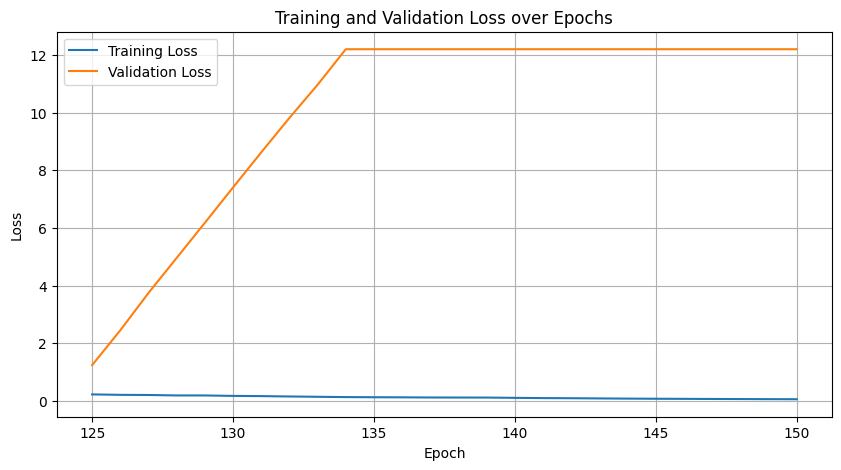

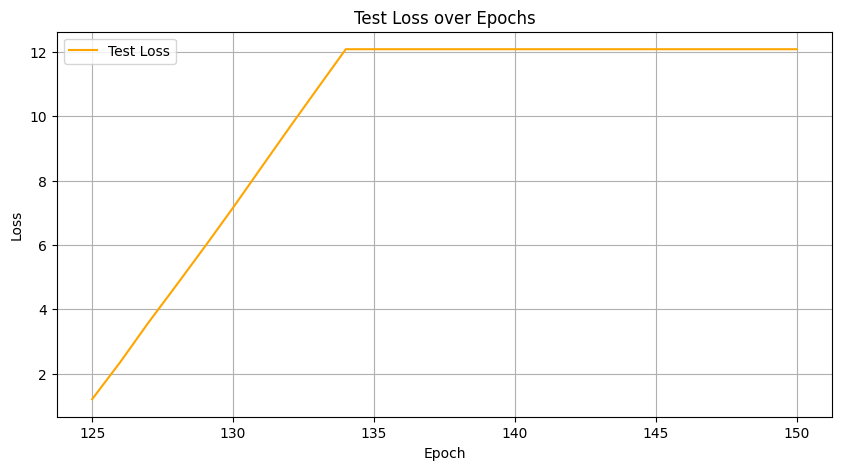

Results Table:
       Metric Training Set  Validation Set  Test Set
0        Loss       0.0569         12.2046   12.0811
1  BLEU Score          N/A          0.3600    0.4600


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
!pip install ace_tools

# Data for training, validation, and test sets
epochs = list(range(125, 151))
train_losses = [
    0.2245, 0.2089, 0.2036, 0.1881, 0.1876, 0.1724, 0.1649, 0.1519, 0.1413,
    0.1308, 0.1256, 0.1224, 0.1171, 0.1152, 0.1146, 0.1046, 0.0959, 0.0915,
    0.0844, 0.0782, 0.0733, 0.0697, 0.0658, 0.0627, 0.0593, 0.0569
]

val_losses = [
    1.2414, 2.4494, 3.7455, 4.9628, 6.1793, 7.4079, 8.6252, 9.8199, 10.9711,
    12.2046, 12.2046, 12.2046, 12.2046, 12.2046, 12.2046, 12.2046, 12.2046,
    12.2046, 12.2046, 12.2046, 12.2046, 12.2046, 12.2046, 12.2046, 12.2046, 12.2046
]

test_losses = [
    1.2062, 2.3623, 3.5896, 4.7601, 5.9464, 7.1562, 8.4032, 9.6444, 10.8664,
    12.0811, 12.0811, 12.0811, 12.0811, 12.0811, 12.0811, 12.0811, 12.0811,
    12.0811, 12.0811, 12.0811, 12.0811, 12.0811, 12.0811, 12.0811, 12.0811, 12.0811
]

val_bleu_score = 0.36
test_bleu_score = 0.46

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses[:len(epochs)], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Test Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_losses[:len(epochs)], label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

# Results table
data = {
    "Metric": ["Loss", "BLEU Score"],
    "Training Set": [train_losses[-1], "N/A"],
    "Validation Set": [val_losses[-1], val_bleu_score],
    "Test Set": [test_losses[-1], test_bleu_score],
}
results_df = pd.DataFrame(data)
print("Results Table:")
print(results_df)
